In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [3]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [4]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [5]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
class FCN8(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN8, self).__init__()
        self.vgg16 = vgg16.features

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)
        self.pool4_conv = nn.Conv2d(512,21,kernel_size=1)
        self.pool3_conv = nn.Conv2d(256,21,kernel_size=1)

        self.upsample2 = nn.ConvTranspose2d(num_class,num_class,2,2,bias=False)
        self.upsample8 = nn.ConvTranspose2d(num_class,num_class,8,8,bias=False)

        # self.relu    = nn.ReLU(inplace=True)
        # self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn1     = nn.BatchNorm2d(512)
        # self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn2     = nn.BatchNorm2d(256)
        # self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn3     = nn.BatchNorm2d(128)
        # self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn4     = nn.BatchNorm2d(64)
        # self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn5     = nn.BatchNorm2d(32)
        # self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
    def forward(self, x):
        pool3 = self.vgg16[:-14](x)
        pool4 = self.vgg16[-14:-7](pool3)
        pool5 = self.vgg16[-7:](pool4)

        #print(pool5.shape)
        pool5 = self.fc1(pool5)
        #print(pool5.shape)
        pool5 = nn.ReLU()(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc2(pool5)
        pool5 = nn.ReLU()(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc3(pool5)

        pool5 = self.upsample2(pool5)
        pool4 = self.pool4_conv(pool4)
        x = pool5 + pool4
        x = self.upsample2(x)
        pool3 = self.pool3_conv(pool3)
        x = x + pool3
        x = self.upsample8(x)

        return x 

        # x = self.relu(self.deconv1(pool5))
        # x = self.bn1(x+pool4)
        # x = self.relu(self.deconv2(x))
        # x = self.bn2(x+pool3)
        # x = self.relu(self.deconv3(x))
        # x = self.bn3(x)
        # x = self.relu(self.deconv4(x))
        # x = self.bn4(x)
        # x = self.relu(self.deconv5(x))
        # x = self.bn5(x)
        # x = self.classifier(x)
        #print(x.shape)
        return x
    def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    m.weight.data.zero_()
                    if m.bias is not None:
                        m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [7]:
FCN =FCN8(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [9]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [10]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN8-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:32, 11.12it/s]
363it [00:28, 12.81it/s]


1 epcoh , time = 61.26
train loss : 1.52814, val_loss : 1.11667
train IoU : 0.11890, val IoU : 0.12988
train Acc : 0.67118, val Acc : 0.74708


366it [00:20, 17.56it/s]
363it [00:18, 19.59it/s]


2 epcoh , time = 39.38
train loss : 1.15482, val_loss : 1.06820
train IoU : 0.12958, val IoU : 0.13031
train Acc : 0.74856, val Acc : 0.74810


366it [00:21, 17.40it/s]
363it [00:18, 19.88it/s]


3 epcoh , time = 39.30
train loss : 1.11534, val_loss : 1.01745
train IoU : 0.13652, val IoU : 0.13881
train Acc : 0.74904, val Acc : 0.75063


366it [00:21, 17.28it/s]
363it [00:18, 19.75it/s]


4 epcoh , time = 39.57
train loss : 1.06090, val_loss : 0.95155
train IoU : 0.15121, val IoU : 0.16370
train Acc : 0.75253, val Acc : 0.75881


366it [00:20, 17.53it/s]
363it [00:18, 19.61it/s]


5 epcoh , time = 39.39
train loss : 0.98933, val_loss : 0.88060
train IoU : 0.17446, val IoU : 0.18420
train Acc : 0.75714, val Acc : 0.76430


366it [00:20, 17.52it/s]
363it [00:18, 19.78it/s]


6 epcoh , time = 39.25
train loss : 0.94251, val_loss : 0.85424
train IoU : 0.18540, val IoU : 0.18602
train Acc : 0.76165, val Acc : 0.76732


366it [00:21, 17.21it/s]
363it [00:18, 19.54it/s]


7 epcoh , time = 39.85
train loss : 0.93105, val_loss : 0.85231
train IoU : 0.18981, val IoU : 0.18848
train Acc : 0.76250, val Acc : 0.77109


366it [00:20, 17.47it/s]
363it [00:19, 18.93it/s]


8 epcoh , time = 40.13
train loss : 0.90775, val_loss : 0.81383
train IoU : 0.19354, val IoU : 0.20627
train Acc : 0.76591, val Acc : 0.77649


366it [00:21, 16.96it/s]
363it [00:18, 19.24it/s]


9 epcoh , time = 40.46
train loss : 0.88517, val_loss : 0.80133
train IoU : 0.20329, val IoU : 0.21418
train Acc : 0.77001, val Acc : 0.78160


366it [00:21, 16.85it/s]
363it [00:18, 19.59it/s]


10 epcoh , time = 40.25
train loss : 0.85766, val_loss : 0.79001
train IoU : 0.21398, val IoU : 0.24393
train Acc : 0.77511, val Acc : 0.78836


366it [00:21, 17.38it/s]
363it [00:18, 19.13it/s]


11 epcoh , time = 40.04
train loss : 0.86457, val_loss : 0.78456
train IoU : 0.21259, val IoU : 0.23860
train Acc : 0.77423, val Acc : 0.78867


366it [00:22, 16.57it/s]
363it [00:18, 19.25it/s]


12 epcoh , time = 40.95
train loss : 0.84362, val_loss : 0.77149
train IoU : 0.21931, val IoU : 0.23739
train Acc : 0.77768, val Acc : 0.78833


366it [00:20, 17.60it/s]
363it [00:18, 19.71it/s]


13 epcoh , time = 39.21
train loss : 0.81700, val_loss : 0.75013
train IoU : 0.23332, val IoU : 0.24926
train Acc : 0.78270, val Acc : 0.79407


366it [00:21, 17.33it/s]
363it [00:18, 19.66it/s]


14 epcoh , time = 39.59
train loss : 0.80753, val_loss : 0.74713
train IoU : 0.24084, val IoU : 0.24794
train Acc : 0.78469, val Acc : 0.79566


366it [00:21, 17.13it/s]
363it [00:18, 19.72it/s]


15 epcoh , time = 39.78
train loss : 0.78155, val_loss : 0.71690
train IoU : 0.24302, val IoU : 0.27444
train Acc : 0.78990, val Acc : 0.80246


366it [00:20, 17.59it/s]
363it [00:18, 19.77it/s]


16 epcoh , time = 39.18
train loss : 0.76164, val_loss : 0.70818
train IoU : 0.25970, val IoU : 0.27913
train Acc : 0.79287, val Acc : 0.80195


366it [00:21, 17.26it/s]
363it [00:18, 19.61it/s]


17 epcoh , time = 39.71
train loss : 0.73247, val_loss : 0.68111
train IoU : 0.27599, val IoU : 0.29963
train Acc : 0.79911, val Acc : 0.81018


366it [00:21, 17.40it/s]
363it [00:18, 19.57it/s]


18 epcoh , time = 39.59
train loss : 0.72192, val_loss : 0.68405
train IoU : 0.27905, val IoU : 0.29433
train Acc : 0.80068, val Acc : 0.80764


366it [00:21, 17.03it/s]
363it [00:18, 19.26it/s]


19 epcoh , time = 40.34
train loss : 0.70476, val_loss : 0.69450
train IoU : 0.29088, val IoU : 0.29396
train Acc : 0.80394, val Acc : 0.80730


366it [00:20, 17.44it/s]
363it [00:19, 18.78it/s]


20 epcoh , time = 40.31
train loss : 0.68844, val_loss : 0.67552
train IoU : 0.29836, val IoU : 0.31656
train Acc : 0.80806, val Acc : 0.81203


366it [00:21, 17.35it/s]
363it [00:18, 19.81it/s]


21 epcoh , time = 39.42
train loss : 0.67902, val_loss : 0.67799
train IoU : 0.30183, val IoU : 0.33189
train Acc : 0.81054, val Acc : 0.81540


366it [00:20, 17.67it/s]
363it [00:18, 19.71it/s]


22 epcoh , time = 39.14
train loss : 0.67310, val_loss : 0.68021
train IoU : 0.30851, val IoU : 0.32049
train Acc : 0.81248, val Acc : 0.81352


366it [00:20, 17.67it/s]
363it [00:18, 19.78it/s]


23 epcoh , time = 39.07
train loss : 0.65663, val_loss : 0.68115
train IoU : 0.31112, val IoU : 0.30961
train Acc : 0.81471, val Acc : 0.81153


366it [00:20, 17.44it/s]
363it [00:18, 19.35it/s]


24 epcoh , time = 39.76
train loss : 0.64205, val_loss : 0.68429
train IoU : 0.32502, val IoU : 0.31771
train Acc : 0.81932, val Acc : 0.81252


366it [00:21, 16.64it/s]
363it [00:19, 18.86it/s]


25 epcoh , time = 41.25
train loss : 0.64207, val_loss : 0.69423
train IoU : 0.32658, val IoU : 0.31404
train Acc : 0.81923, val Acc : 0.81132


366it [00:21, 16.94it/s]
363it [00:18, 19.79it/s]


26 epcoh , time = 39.95
train loss : 0.63178, val_loss : 0.69565
train IoU : 0.33078, val IoU : 0.31656
train Acc : 0.82205, val Acc : 0.81024


366it [00:22, 16.61it/s]
363it [00:18, 19.68it/s]


27 epcoh , time = 40.49
train loss : 0.61278, val_loss : 0.68264
train IoU : 0.33955, val IoU : 0.32667
train Acc : 0.82604, val Acc : 0.81387


366it [00:21, 17.17it/s]
363it [00:18, 19.25it/s]


28 epcoh , time = 40.18
train loss : 0.60395, val_loss : 0.71557
train IoU : 0.34145, val IoU : 0.29152
train Acc : 0.82670, val Acc : 0.80834


366it [00:21, 17.15it/s]
363it [00:18, 19.54it/s]


29 epcoh , time = 39.93
train loss : 0.60014, val_loss : 0.70422
train IoU : 0.34957, val IoU : 0.31979
train Acc : 0.82885, val Acc : 0.81408


366it [00:20, 17.65it/s]
363it [00:18, 19.56it/s]


30 epcoh , time = 39.30
train loss : 0.59367, val_loss : 0.68538
train IoU : 0.35073, val IoU : 0.33754
train Acc : 0.82990, val Acc : 0.81606


366it [00:20, 17.70it/s]
363it [00:18, 19.62it/s]


31 epcoh , time = 39.19
train loss : 0.58959, val_loss : 0.69361
train IoU : 0.35242, val IoU : 0.33852
train Acc : 0.82998, val Acc : 0.81517


366it [00:21, 17.25it/s]
363it [00:18, 19.65it/s]


32 epcoh , time = 39.69
train loss : 0.56618, val_loss : 0.69148
train IoU : 0.36967, val IoU : 0.34690
train Acc : 0.83587, val Acc : 0.81783


366it [00:21, 17.28it/s]
363it [00:18, 19.86it/s]


33 epcoh , time = 39.46
train loss : 0.56902, val_loss : 0.68257
train IoU : 0.36587, val IoU : 0.35666
train Acc : 0.83676, val Acc : 0.81638


366it [00:21, 17.23it/s]
363it [00:18, 19.62it/s]


34 epcoh , time = 39.75
train loss : 0.54975, val_loss : 0.68053
train IoU : 0.37474, val IoU : 0.37158
train Acc : 0.83891, val Acc : 0.81887


366it [00:20, 17.72it/s]
363it [00:18, 19.78it/s]


35 epcoh , time = 39.01
train loss : 0.55253, val_loss : 0.70914
train IoU : 0.37733, val IoU : 0.34366
train Acc : 0.83924, val Acc : 0.81291


366it [00:20, 17.62it/s]
363it [00:18, 19.63it/s]


36 epcoh , time = 39.27
train loss : 0.54361, val_loss : 0.71888
train IoU : 0.38126, val IoU : 0.32226
train Acc : 0.84107, val Acc : 0.81182


366it [00:20, 17.48it/s]
363it [00:18, 19.64it/s]


37 epcoh , time = 39.42
train loss : 0.52972, val_loss : 0.72754
train IoU : 0.38917, val IoU : 0.33105
train Acc : 0.84416, val Acc : 0.81084


366it [00:20, 17.70it/s]
363it [00:19, 19.09it/s]


38 epcoh , time = 39.70
train loss : 0.53851, val_loss : 0.71326
train IoU : 0.38474, val IoU : 0.35373
train Acc : 0.84240, val Acc : 0.81525


366it [00:21, 16.99it/s]
363it [00:18, 19.43it/s]


39 epcoh , time = 40.24
train loss : 0.52494, val_loss : 0.70802
train IoU : 0.39911, val IoU : 0.35499
train Acc : 0.84760, val Acc : 0.81884


366it [00:21, 17.40it/s]
363it [00:18, 19.53it/s]


40 epcoh , time = 39.63
train loss : 0.51666, val_loss : 0.72596
train IoU : 0.39696, val IoU : 0.33698
train Acc : 0.84860, val Acc : 0.81625


366it [00:20, 17.43it/s]
363it [00:18, 19.81it/s]


41 epcoh , time = 39.33
train loss : 0.50191, val_loss : 0.72447
train IoU : 0.40761, val IoU : 0.33396
train Acc : 0.85086, val Acc : 0.81726


366it [00:20, 17.51it/s]
363it [00:19, 18.79it/s]


42 epcoh , time = 40.23
train loss : 0.49339, val_loss : 0.75258
train IoU : 0.41106, val IoU : 0.33396
train Acc : 0.85383, val Acc : 0.81460


366it [00:20, 17.43it/s]
363it [00:18, 19.28it/s]


43 epcoh , time = 39.83
train loss : 0.49701, val_loss : 0.74466
train IoU : 0.41028, val IoU : 0.33832
train Acc : 0.85287, val Acc : 0.81503


366it [00:21, 17.09it/s]
363it [00:18, 19.73it/s]


44 epcoh , time = 39.82
train loss : 0.48729, val_loss : 0.73985
train IoU : 0.41736, val IoU : 0.35696
train Acc : 0.85589, val Acc : 0.81329


366it [00:20, 17.60it/s]
12it [00:00, 19.71it/s]


KeyboardInterrupt: 

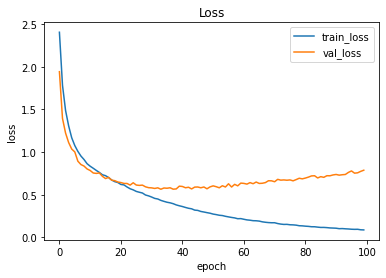

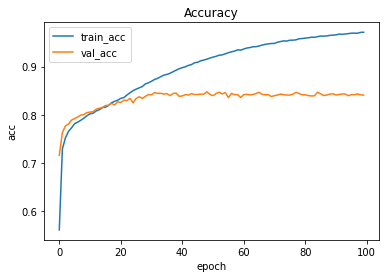

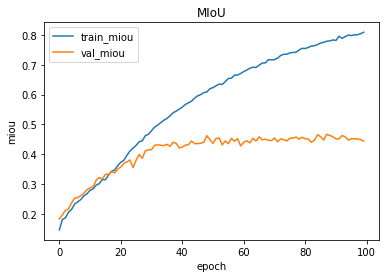

In [ ]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [ ]:
best=torch.load('./models/FCN8-Vgg16.pt')

In [ ]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

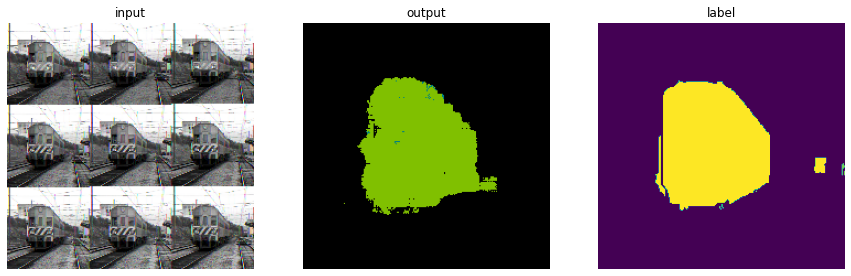

In [ ]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.reshape(img.shape[1], img.shape[2], img.shape[0])

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label[0])
        break
